<a href="https://colab.research.google.com/github/motazsaad/infant-cry-care/blob/main/deepLearningCryCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())
title = 'CryCareSheet'
spreedSheet = gc.open(title)
audioContSheet = spreedSheet.sheet1

In [ ]:
!pip install split-folders

In [ ]:
import glob
import subprocess
import os
import pandas as pd
import librosa 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from gspread_dataframe import set_with_dataframe
import IPython.display as ipd
import tensorflow as tf
import pickle
import numpy as np
from keras.preprocessing import image
import cv2
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

mainPath = '/content/drive/MyDrive/CryCareDataset/'
exp4Path = mainPath + 'generatedData/Exp4/'

directories = ['Hungry', 'lower gas', 'burp up', 'normal','pain','asphyxia', 'Uncomfortable', 'Sleepy'] 

In [ ]:
import splitfolders
def splitFolders(path):
  splitfolders.ratio(path, output= path + "output",  ratio=(.75,.25), group_prefix=None) 

splitFolders(mainPath +'img_data/')

Copying files: 7820 files [03:26, 37.93 files/s]


In [ ]:
def makeDirectory(newPath):
  try:
    # os.mkdir(newPath)
    for directoryName in directories:
      os.mkdir(newPath + directoryName)
  except:
    print('File exists')
makeDirectory(mainPath + 'img_data/')

In [ ]:
import matplotlib.pyplot as plt
def audioFeatureExtraction():
  for directory in directories :
    for filename in glob.glob(exp4Path + directory + '/**.wav'):
        audiofile, sr = librosa.load(filename, sr = 11025, mono = True)
        # fingerprint= mfcc(audiofile)
        # mfcc_features.append(mfcc(audiofile))
        plt.specgram(audiofile, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='CMRmap', sides='default', mode='default', scale='dB');
        plt.axis('off');
        name = filename.split('/')[-1]
        plt.savefig(f'{mainPath}img_data/{directory}/{name[:-3].replace(".", "")}.png')
        plt.clf()
  # mfcc_features = np.array(mfcc_features)
  # y = np.array(y)

  # return mfcc_features, y
audioFeatureExtraction()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


<Figure size 432x288 with 0 Axes>

In [ ]:
def exportClassificationReport(report, sheetName, directories):
  df = pd.DataFrame(report).transpose()
  df[''] = directories + ['accuracy', 'macro avg', 'weighted avg']
  try:
    spreedSheet.add_worksheet(title =sheetName, rows = 200, cols = 100)
  except:
    print('file exist')
  reportSheet = spreedSheet.worksheet(sheetName)
  set_with_dataframe(reportSheet, df) 
  # return df

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(mainPath +'img_data/output/train',
                                                 target_size = (256, 256),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(mainPath +'img_data/output/val',
                                            target_size = (256, 256),
                                            batch_size = 64,
                                            class_mode = 'categorical')
print("Image Processing.......Compleated")

Found 5863 images belonging to 8 classes.
Found 1957 images belonging to 8 classes.
Image Processing.......Compleated


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode ="min", patience = 5,  restore_best_weights = True)  
cnn = tf.keras.models.Sequential()
print("Building Neural Network.....")
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=4, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=4, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=4, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=900, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.Dense(units=700, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(units=500, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print("Training cnn")

#######
logFile=mainPath + 'logCNN2.csv'
history_logger=tf.keras.callbacks.CSVLogger(logFile, separator=",", append=True)
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 50, callbacks=[early_stopping,history_logger])

Building Neural Network.....
Training cnn
Epoch 1/50
92/92 [==============================] - 582s 6s/step - loss: 1.8292 - accuracy: 0.3021 - val_loss: 1.4870 - val_accuracy: 0.4272
Epoch 2/50
92/92 [==============================] - 572s 6s/step - loss: 1.4004 - accuracy: 0.4667 - val_loss: 1.1803 - val_accuracy: 0.5416
Epoch 3/50
92/92 [==============================] - 594s 6s/step - loss: 1.1481 - accuracy: 0.5557 - val_loss: 0.9760 - val_accuracy: 0.6265
Epoch 4/50
92/92 [==============================] - 560s 6s/step - loss: 0.9653 - accuracy: 0.6244 - val_loss: 0.7949 - val_accuracy: 0.6811
Epoch 5/50
92/92 [==============================] - 558s 6s/step - loss: 0.8286 - accuracy: 0.6735 - val_loss: 0.7120 - val_accuracy: 0.7261
Epoch 6/50
92/92 [==============================] - 565s 6s/step - loss: 0.7384 - accuracy: 0.7164 - val_loss: 0.6575 - val_accuracy: 0.7624
Epoch 7/50
92/92 [==============================] - 562s 6s/step - loss: 0.6818 - accuracy: 0.7428 - val_loss: 0

INFO:tensorflow:Assets written to: ram://fe8f37b0-83e1-4034-99c7-704f98af8d33/assets


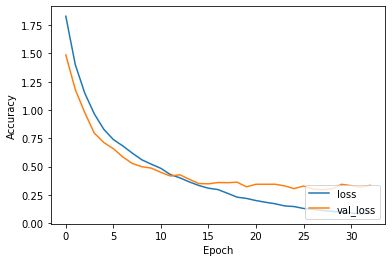

In [ ]:
import matplotlib.pyplot as plt
import pickle

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
filename = mainPath + 'cnn.sav'
pickle.dump(cnn, open(filename, 'wb'))

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set1 = test_datagen.flow_from_directory(mainPath +'img_data/output/val',
                                            target_size = (256, 256),
                                            batch_size = 64,
                                            class_mode = None,
                                            shuffle=False)
filename = mainPath + 'cnn.sav'

cnn2 = pickle.load(open(filename, 'rb'))


Found 1957 images belonging to 8 classes.


In [ ]:
y_test=[]
i = 0
directories=['Hungry','Sleepy','Uncomfortable','asphyxia','burp up','lower gas','normal','pain']
for directory in directories :
    print(directory, i) 
    for filename in glob.glob(mainPath +'img_data/output/val/' + directory + '/**.png'):
      # print(filename, i)
      y_test.append(i)
    i = i+1
# df = pd.DataFrame(y_test)
# df.to_csv(mainPath + 'y_test.csv')

Hungry 0
Sleepy 1
Uncomfortable 2
asphyxia 3
burp up 4
lower gas 5
normal 6
pain 7


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

predict_y = cnn2.predict(test_set1)


In [ ]:
predict = cnn.evaluate(test_set1)

31/31 [==============================] - 14s 432ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [ ]:
predicted_classes = np.argmax(np.round(predict_y),axis=1)
print(predict_y[200],y_test[700], predicted_classes[700])
# from sklearn.metrics import accuracy_score, classification_report
directories=['Hungry','Sleepy','Uncomfortable','asphyxia','burp up','lower gas','normal','pain']

report = classification_report( predicted_classes,y_test,output_dict=True)
exportClassificationReport(report, 'CNN-Final', directories)

# test_set.filenames[1000:]
# predicted_classes
report


[9.7607976e-01 4.6583856e-03 1.6666165e-02 1.0043973e-06 1.7178266e-03
 7.9245743e-04 3.4970573e-05 4.9424947e-05] 2 2
file exist


{'0': {'f1-score': 0.8339973439575034,
  'precision': 0.8532608695652174,
  'recall': 0.8155844155844156,
  'support': 385},
 '1': {'f1-score': 0.8997668997668998,
  'precision': 0.8616071428571429,
  'recall': 0.9414634146341463,
  'support': 205},
 '2': {'f1-score': 0.8267477203647416,
  'precision': 0.8717948717948718,
  'recall': 0.7861271676300579,
  'support': 173},
 '3': {'f1-score': 0.978085351787774,
  'precision': 0.9976470588235294,
  'recall': 0.9592760180995475,
  'support': 442},
 '4': {'f1-score': 0.8636363636363636,
  'precision': 0.8321167883211679,
  'recall': 0.8976377952755905,
  'support': 127},
 '5': {'f1-score': 0.8669950738916257,
  'precision': 0.8380952380952381,
  'recall': 0.8979591836734694,
  'support': 98},
 '6': {'f1-score': 0.9758064516129031,
  'precision': 0.952755905511811,
  'recall': 1.0,
  'support': 242},
 '7': {'f1-score': 0.9144851657940664,
  'precision': 0.9097222222222222,
  'recall': 0.9192982456140351,
  'support': 285},
 'accuracy': 0.905